In [1]:
import pandas as pd 
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler



In [2]:
# Read data 

df = pd.read_csv('../../data.csv')

C:\Users\User\AppData\Local\Temp\ipykernel_9564\14438960.py:3: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../../data.csv')


In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Functions for later use

#### Stratified sampling Function

In [4]:
# Stratified sampling

def StratifiedSampling(X,y, test_size=0.2, random_state=42):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, 
                                                        random_state=random_state)
    
    return X_train, X_test, y_train, y_test

### Oversampling function

In [5]:
def Oversampling(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, 
                                                        random_state=random_state)
    # Instantiate the SMOTE object
    smote = SMOTE(random_state=42)
    # Perform SMOTE only on the training data
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    return X_train_balanced, X_test, y_train_balanced, y_test

### evaluate_predictions function
#### for metric presentations

In [6]:
def evaluate_predictions(y_true, y_pred, model_name):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], 
                yticklabels=['Non-default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=['Non-default', 'Default'], output_dict=True)

    # Create a summary table
    summary_table = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'ROC-AUC Score': [roc_auc],
        'Precision (Non-default)': [report['Non-default']['precision']],
        'Recall (Non-default)': [report['Non-default']['recall']],
        'F1-score (Non-default)': [report['Non-default']['f1-score']],
        'Precision (Default)': [report['Default']['precision']],
        'Recall (Default)': [report['Default']['recall']],
        'F1-score (Default)': [report['Default']['f1-score']],
    })

    return summary_table

# Data discovery

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 855969 entries, 0 to 855968
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           855969 non-null  int64  
 1   member_id                    855969 non-null  int64  
 2   loan_amnt                    855969 non-null  int64  
 3   funded_amnt                  855969 non-null  int64  
 4   funded_amnt_inv              855969 non-null  float64
 5   term                         855969 non-null  object 
 6   int_rate                     855969 non-null  float64
 7   installment                  855969 non-null  float64
 8   grade                        855969 non-null  object 
 9   sub_grade                    855969 non-null  object 
 10  emp_title                    806526 non-null  object 
 11  emp_length                   812908 non-null  object 
 12  home_ownership               855969 non-null  object 
 13 

In [8]:
# Check the null value in each attributes

df.isnull().sum()

id                       0
member_id                0
loan_amnt                0
funded_amnt              0
funded_amnt_inv          0
                     ...  
total_rev_hi_lim     67313
inq_fi              842681
total_cu_tl         842681
inq_last_12m        842681
default_ind              0
Length: 73, dtype: int64

# Data pre-processing

In [9]:
# total_rev_hi_lim 

# Fill missing values in total_rev_hi_lim with Simple Imputer

imputer = SimpleImputer(strategy='median')
total_rev_hi_lim = df['total_rev_hi_lim'].values.reshape(-1,1)
total_rev_hi_lim_imputed = imputer.fit_transform(total_rev_hi_lim)
df['total_rev_hi_lim'] = total_rev_hi_lim_imputed

In [10]:
# home_ownership 

# Remove rows with value ANY

df = df[df['home_ownership'] != 'ANY']
df['home_ownership'].unique()

# Level encoding for home ownership 

home_type = ['RENT', 'OWN', 'MORTGAGE', 'OTHER', 'NONE']  # Unique values for encoding

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(home_type)

# Encode the 'grade' column in the DataFrame
df['home_ownership'] = encoder.transform(df['home_ownership'])


In [11]:
# Purpose 

# Label encoding for purpose

df['purpose'].unique()

purposes = ['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational']

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(purposes)
# Encode the 'grade' column in the DataFrame
df['purpose'] = encoder.transform(df['purpose'])


In [12]:
# sub_grade

# Sort the order of subgrades and do label encoding

subgrades = ['B2', 'C4', 'C5', 'C1', 'B5', 'A4', 'E1', 'F2', 'C3', 'B1', 'D1',
       'A1', 'B3', 'B4', 'C2', 'D2', 'A3', 'A5', 'D5', 'A2', 'E4', 'D3',
       'D4', 'F3', 'E3', 'F4', 'F1', 'E5', 'G4', 'E2', 'G3', 'G2', 'G1',
       'F5', 'G5']

def custom_sort_key(subgrade):
    match = re.match(r'([A-Za-z]+)(\d+)', subgrade)
    letter = match.group(1)
    number = int(match.group(2))
    
    return letter, number

sorted_subgrades = sorted(subgrades, key=custom_sort_key)

# Level encoding for sorted sub-grade 

encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(sorted_subgrades)

# Encode the 'grade' column in the DataFrame
df['sub_grade'] = encoder.transform(df['sub_grade'])

In [13]:
# employment_lengths

employment_lengths = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', 
                        '7 years', '8 years', '9 years', '10+ years', 'nan']

label_encoder = LabelEncoder()

# Fit the LabelEncoder with unique values
label_encoder.fit(employment_lengths)

# Encode the attribute values
df['emp_length'] = label_encoder.transform(df['emp_length'])

In [14]:
# mths_since_last_delinq

df['mths_since_last_delinq'] = df['mths_since_last_delinq'].fillna(-1)

In [15]:
# mths_since_last_record

df['mths_since_last_record'] = df['mths_since_last_record'].fillna(-1)

In [16]:
# revol_util
# Handle missing value with imputer

imputer = SimpleImputer(strategy='mean')

revol_util = df['revol_util'].values.reshape(-1,1)

revol_util_imputed = imputer.fit_transform(revol_util)

df['revol_util'] = revol_util_imputed

In [17]:
# aggregate annual_inc and annual_inc_joint

df.loc[df['application_type'] 
== 'JOINT', 'annual_inc'] = df.loc[df['application_type'] == 'JOINT', 'annual_inc_joint']

df = df.drop('annual_inc_joint', axis=1)

In [18]:
# dti_joint

df.loc[df['application_type'] 
       == 'JOINT', 'dti'] = df.loc[df['application_type'] == 'JOINT', 'dti_joint']
df = df.drop('dti_joint', axis=1)

In [19]:
# verification_status_joint

df.loc[df['application_type'] 
== 'JOINT', 'verification_status'] = df.loc[df['application_type'] == 'JOINT', 'verification_status_joint']
df = df.drop('verification_status_joint', axis=1)

In [20]:
# term 
# Label encoding for term

term = [' 36 months', ' 60 months']  # Unique values for encoding

# Create an instance of LabelEncoder
encoder = LabelEncoder()

# Fit the encoder on the grades
encoder.fit(term)

# Encode the 'grade' column in the DataFrame
df['term'] = encoder.transform(df['term'])

In [21]:
# verification_status

veri = ['Not Verified', 'Source Verified', 'Verified']  # Unique values for encoding

encoder = LabelEncoder()

encoder.fit(veri)


df['verification_status'] = encoder.transform(df['verification_status'])

In [22]:
# pymnt_plan

plan = ['n', 'y']  # Unique values for encoding

encoder = LabelEncoder()
encoder.fit(plan)
df['pymnt_plan'] = encoder.transform(df['pymnt_plan'])

In [23]:
# application_type

type = ['INDIVIDUAL', 'JOINT'] # Unique values for encoding

encoder = LabelEncoder()

encoder.fit(type)

df['application_type'] = encoder.transform(df['application_type'])

In [24]:

# initial_list_status

status = ['f', 'w'] # Unique values for encoding

encoder = LabelEncoder()

encoder.fit(status)

df['initial_list_status'] = encoder.transform(df['initial_list_status'])

In [25]:
# Fill missing last credit pull
df['last_credit_pull_d'].fillna("01-01-2016", inplace=True)

In [26]:
# Credit History Length:
# Calculated as: last_credit_pull - earliest_cr_line
def date_difference(date_str1, date_str2):
    # Convert date strings to datetime objects
    date_format = "%d-%m-%Y"
    date1 = datetime.strptime(date_str1, date_format)
    date2 = datetime.strptime(date_str2, date_format)

    # Calculate the difference
    difference = date2 - date1

    # Return the difference in days
    return difference.days

df['credit_history_length'] = df.apply(lambda row: date_difference(row['earliest_cr_line'],
                                         row['last_credit_pull_d']), axis=1)

# Swap the values and column names
df['default_ind'], df['credit_history_length'] = df['credit_history_length'], df['default_ind']
df.rename(columns={'default_ind': 'credit_history_length', 'credit_history_length': 'default_ind'}, 
                    inplace=True)


In [27]:
# Drop not usable attributes 

remove_col = [
    'id',
    'member_id',
    'emp_title',
    'issue_d',
    'desc',
    'title',
    'zip_code',
    'addr_state',
    'earliest_cr_line',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'next_pymnt_d',
    'last_credit_pull_d',
    'collections_12_mths_ex_med',
    'mths_since_last_major_derog',
    'policy_code',
    'tot_coll_amt',
    'tot_cur_bal', 
    'open_acc_6m',
    'open_il_6m', 
    'open_il_12m', 
    'open_il_24m', 
    'mths_since_rcnt_il', 
    'total_bal_il', 
    'il_util', 
    'open_rv_12m' ,
    'open_rv_24m', 
    'max_bal_bc', 
    'all_util', 
    'inq_fi', 
    'total_cu_tl', 
    'inq_last_12m',
    'grade'
]

df = df.drop(remove_col, axis=1)

In [28]:
df.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,...,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,application_type,acc_now_delinq,total_rev_hi_lim,credit_history_length,default_ind
0,5000,5000,4975.0,0,10.65,162.87,6,1,4,24000.0,...,5000.00,861.07,0.00,0.00,0.00,0,0,23800.0,11322,0
1,2500,2500,2500.0,1,15.27,59.83,13,10,4,30000.0,...,456.46,435.17,0.00,117.08,1.11,0,0,23800.0,5267,1
2,2400,2400,2400.0,0,15.96,84.33,14,1,4,12252.0,...,2400.00,603.65,0.00,0.00,0.00,0,0,23800.0,5174,0
3,10000,10000,10000.0,0,13.49,339.31,10,1,4,49200.0,...,10000.00,2209.33,16.97,0.00,0.00,0,0,23800.0,6909,0
4,3000,3000,3000.0,1,12.69,67.79,9,0,4,80000.0,...,2233.10,1009.07,0.00,0.00,0.00,0,0,23800.0,7305,0


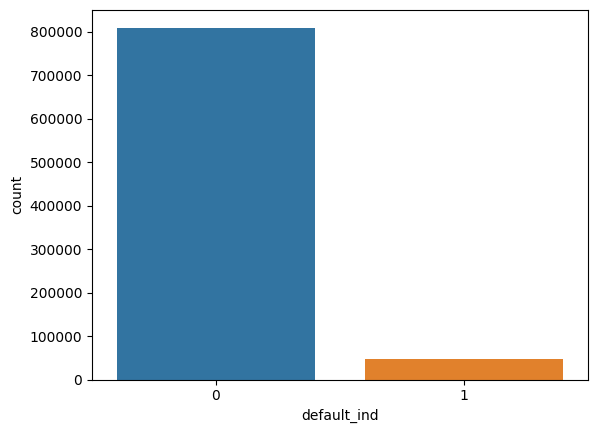

In [29]:
# Visualize default_ind attribute

sns.countplot(data=df, x='default_ind')
plt.show()

## New feature using user defined transformer

In [30]:
class CreditUtilizationRatioTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, include=True):
        self.revol_bal_col = 'revol_bal'
        self.annual_inc_col = 'annual_inc'
        self.installment_col = 'installment'
        self.total_rec_prncp_col = 'total_rec_prncp'
        self.funded_amnt_col = 'funded_amnt'

        self.include_rev_to_inc_ratio = include
        self.include_loan_to_inc_ratio = include
        self.include_repayment_progress = include


    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Find index of columns
        revol_bal_ix = np.where(X.columns == self.revol_bal_col)[0][0]
        annual_inc_ix = np.where(X.columns == self.annual_inc_col)[0][0]
        installment_ix = np.where(X.columns == self.installment_col)[0][0]
        total_rec_prncp_ix = np.where(X.columns == self.total_rec_prncp_col)[0][0]
        funded_amnt_ix = np.where(X.columns == self.funded_amnt_col)[0][0]

        # Calculate the Revolving Credit Balance to Annual Income Ratio.
        rev_to_inc_ratio = X.iloc[:, revol_bal_ix] / X.iloc[:, annual_inc_ix]

        # Calculate the Loan Payment-to-Income Ratio.
        loan_to_inc_ratio = X.iloc[:, installment_ix] / (X.iloc[:, annual_inc_ix] / 12)

        # Calculate the Repayment Progress.
        repayment_progress = (X.iloc[:, total_rec_prncp_ix] / X.iloc[:, funded_amnt_ix]) * 100

        # Create a copy of the original DataFrame to avoid modifying it directly
        X_transformed = X.copy()

        # Add the new columns to the DataFrame using .loc
        if self.include_rev_to_inc_ratio:
            X_transformed.loc[:, 'Rev_to_Inc_Ratio'] = rev_to_inc_ratio

        if self.include_loan_to_inc_ratio:
            X_transformed.loc[:, 'Loan_Payment_to_Income_Ratio'] = loan_to_inc_ratio

        if self.include_repayment_progress:
            X_transformed.loc[:, 'Repayment_Progress'] = repayment_progress

        return X_transformed


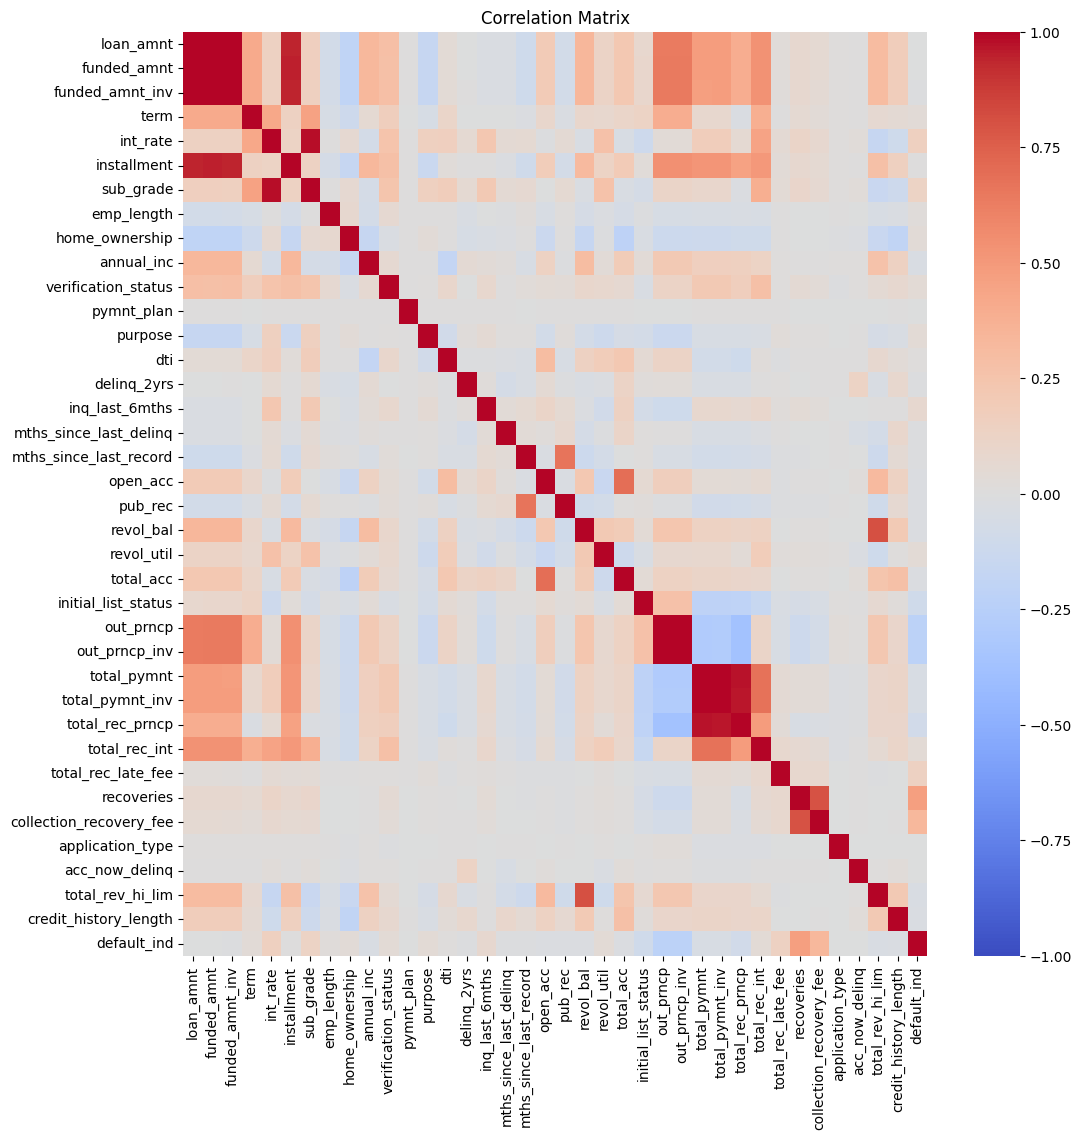

In [31]:
# Visualize - Correlation matrix

# Create a correlation matrix
corr_matrix = df.corr()

# Select the correlation values with 'default_ind'
target_corr = corr_matrix['default_ind']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

## Feature selection

In [32]:
# Define the features (subset of columns from the original dataset)
selected_features = [
    'collection_recovery_fee'   ,                  
    'acc_now_delinq' ,                                    
    'funded_amnt'   ,               
    'funded_amnt_inv'   ,            
    'mths_since_last_record' ,       
    'delinq_2yrs'   ,                          
    'dti'            ,              
    'mths_since_last_delinq'  ,       
    'emp_length',                      
    'pub_rec'   ,                  
    'revol_bal'    ,                                
    'credit_history_length'  ,        
    'term'   ,                       
    'home_ownership' ,                                
    'total_rev_hi_lim'  ,              
    'total_pymnt'      ,                     
    'total_pymnt_inv'  ,              
    'purpose'   ,                   
    'revol_util'   ,                 
    'total_rec_int'   ,               
    'inq_last_6mths'  ,              
    'total_rec_prncp' ,                        
    'sub_grade'        ,             
    'total_rec_late_fee'   ,          
    'int_rate'   ,                    
    'out_prncp_inv'  ,                 
    'out_prncp'   ,                       
    'recoveries'                     
]


# Define the features (subset of columns from the original dataset)
# selected_features = ['recoveries', 'collection_recovery_fee', 'out_prncp', 'out_prncp_inv', 'sub_grade', 'revol_bal', 'annual_inc', 'installment', 'total_rec_prncp', 'funded_amnt']

# Create the feature matrix X by selecting the columns from the original dataset
X_before_transformed = df[selected_features]
y = df['default_ind']

### StratifiedShuffleSplit Sampling

In [33]:
before_X_train, before_X_test, before_y_train, before_y_test = StratifiedSampling(X_before_transformed, y)

In [34]:
# # Instantiate the StratifiedShuffleSplit object
# stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# # Perform the split and obtain the indices for training and testing sets
# for train_index, test_index in stratified_shuffle_split.split(X_before_transformed, y):
#     before_X_train, before_X_test = X_before_transformed.iloc[train_index], X_before_transformed.iloc[test_index]
#     before_y_train, before_y_test = y.iloc[train_index], y.iloc[test_index]


#### Visualisation of Test and Train shape

In [35]:
print("before_X_train shape:", before_X_train.shape)
print("before_X_test shape:", before_X_test.shape)
print("before_y_train shape:", before_y_train.shape)
print("before_y_test shape:", before_y_test.shape)

before_X_train shape: (684772, 28)
before_X_test shape: (171194, 28)
before_y_train shape: (684772,)
before_y_test shape: (171194,)


#### Result: Significantly imbalanced class distribution

#### Solution: Have to apply class balancing techniques (e.g. oversampling/SMOTE, or Class-Weighted approach) just before Model training



### Add User-defined Transformer Features to X

In [36]:
# Decide to use new generated features

transformer_with_features = CreditUtilizationRatioTransformer(include=True)

# Apply the transformer to add the new features to df.
new_df = transformer_with_features.transform(df)
new_selected_features = selected_features

new_selected_features.append('Repayment_Progress')
new_selected_features.append('Loan_Payment_to_Income_Ratio')
new_selected_features.append('Rev_to_Inc_Ratio')
X_transformed = new_df[new_selected_features]
# new_y1 = NB_df['default_ind']

In [37]:
# Create an instance of CreditUtilizationRatioTransformer with desired features included
# transformer = CreditUtilizationRatioTransformer(
#     include= True
# )
# # Apply the transformer to add the new features to X
# X_transformed = transformer.transform(X_before_transformed)

# Now X contains the original selected features along with additional features from the transformer

#### StratifiedShuffleSplit Re-Sampling

In [38]:
Balanced_X_train, Balanced_X_test, Balanced_y_train, Balanced_y_test = StratifiedSampling(X_transformed, y)

In [39]:
# Instantiate the StratifiedShuffleSplit object
# stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# # Perform the split and obtain the indices for training and testing sets
# for train_index, test_index in stratified_shuffle_split.split(X_transformed, y):
#     Balanced_X_train, Balanced_X_test = X_transformed.iloc[train_index], X_transformed.iloc[test_index]
#     Balanced_y_train, Balanced_y_test = y.iloc[train_index], y.iloc[test_index]


#### Visualisation of Test and Train shape

In [40]:
print("Balanced_X_train shape:", Balanced_X_train.shape)
print("Balanced_X_test shape:", Balanced_X_test.shape)
print("Balanced_y_train shape:", Balanced_y_train.shape)
print("Balanced_y_test shape:", Balanced_y_test.shape)

Balanced_X_train shape: (684772, 31)
Balanced_X_test shape: (171194, 31)
Balanced_y_train shape: (684772,)
Balanced_y_test shape: (171194,)


# Model selection and training

# K-Nearest Neighbors (KNN) Model 

## 1) Fresh round of training

#### Convert into NP array for KNN

In [116]:
KNN_before_X_test = np.array(before_X_test)
KNN_Balance_X_test = np.array(Balanced_X_test)

### Basic KNN Model training

In [117]:
KNN_basic_classifier = KNeighborsClassifier(n_neighbors=5)

# Train the classifier on the training data
KNN_basic_classifier.fit(before_X_train, before_y_train)

# Make predictions on the testing data
KNN_basic_y_pred = KNN_basic_classifier.predict(KNN_before_X_test)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


## 2) Fine tune the model

### 2a: Hyperparameter

#### Finding the nearest n_neighbour

In [ ]:
'''

# Define the range of n_neighbors to test
param_grid = {'n_neighbors': range(3, 6)}

# Initialize the KNN classifier
KNNclassifier = KNeighborsClassifier(weights='distance')

# Use GridSearchCV or RandomizedSearchCV for hyperparameter tuning
# For GridSearchCV:
grid_search = GridSearchCV(KNNclassifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(Balanced_X_train, Balanced_y_train)

# For RandomizedSearchCV:
# randomized_search = RandomizedSearchCV(classifier, param_distributions=param_grid, 
# cv=5, scoring='accuracy', n_jobs=-1, n_iter=10)

# randomized_search.fit(Balanced_X_train, Balanced_y_train)

# Print the best hyperparameters and the corresponding performance
print("Best n_neighbors:", grid_search.best_params_['n_neighbors'])

'''


### 2b: Training KNN Model using SMOTE approach


In [ ]:
# Instantiate the SMOTE object
smote = SMOTE(random_state=42)

# Perform SMOTE only on the training data
KNN_balanced_X_train, KNN_balanced_y_train= smote.fit_resample(Balanced_X_train, Balanced_y_train)


#### Visualising Data Shape Before and After SMOTE

In [ ]:
# Before SMOTE
print("Class distribution before SMOTE:")
print(pd.Series(Balanced_y_train).value_counts())

# After SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(KNN_balanced_y_train).value_counts())

#### Training Model

In [ ]:
# Train the classifier on the training data with SMOTE
KNN_classifier_smote = KNeighborsClassifier(n_neighbors=4)
KNN_classifier_smote.fit(Balanced_X_train, Balanced_y_train)

In [ ]:
# Make predictions on the test set using the trained model
KNN_smote_y_pred = KNN_classifier_smote.predict(KNN_Balance_X_test)

# Calculate evaluation metrics for the test set
accuracy_smote = accuracy_score(Balanced_y_test, KNN_smote_y_pred)
roc_auc_smote = roc_auc_score(Balanced_y_test, KNN_smote_y_pred)

### 2d: Training KNN Model using Class-Weighted approach

#### Training  Model 

In [ ]:
#  set the weights parameter to 'distance'
# 'distance' means weights are assigned based on the inverse of the distance
class_classifier = KNeighborsClassifier(n_neighbors=4, weights='distance')

# Train the classifier on the training data with class weights
class_classifier.fit(Balanced_X_train, Balanced_y_train)


In [ ]:
# Make predictions on the testing data
KNN_class_y_pred = class_classifier.predict(KNN_Balance_X_test)

# Calculate evaluation metrics
class_accuracy = accuracy_score(Balanced_y_test, KNN_class_y_pred)
roc_auc = roc_auc_score(Balanced_y_test, KNN_class_y_pred)


## 3) Evaluate the outcome

#### 3a: Comparison

In [ ]:
# Calls evalutation)predictions() to display metric results
basic_summary = evaluate_predictions(Balanced_y_test, KNN_basic_y_pred, "Basic Model")
smote_summary = evaluate_predictions(Balanced_y_test, KNN_smote_y_pred, "Balanced Model")
class_summary = evaluate_predictions(Balanced_y_test, KNN_class_y_pred, "Class Model")

# Combine all summaries into one DataFrame
all_summaries = pd.concat([basic_summary, smote_summary, class_summary], ignore_index=True)

# Display the summary table
print(all_summaries)


#### 3b: 
#### Considerations: 
#### For predicting 'default_rate'
#### Overall Accuracy - The overall measure on how well the model predicts both the positive and negative rate. Class Model does have an edge here.
#### Recall - This is important as the cost of a false-negative is high, especially in our case of loan default prediction, a false negative would mean that the model fails to identify a loan that will actually default. This could result in potential losses for the lender. 
#### Conclusion: Since Class-Weighted approach have better scores across almost all metrics, therefore it is best to use this approach
#### 

# Decision Tree Model


## 1. Fresh Round of Training

#### 1a: Basic Decision Tree Model Training

In [60]:
# Create a Decision Tree Classifier with random state = 42
DT_classifier = DecisionTreeClassifier()

# Train the classifier
DT_classifier.fit(before_X_train, before_y_train)

# Make predictions on the test set
DT_y_pred_basic = DT_classifier.predict(before_X_test)

#### 1b: Basic decision tree model + SMOTE

In [42]:
# Instantiate the SMOTE object
smote = SMOTE(random_state=42)

# Perform SMOTE only on the training data
DT_X_train_balance, DT_X_test, DT_y_train_balance, DT_y_test = Oversampling(X_before_transformed, y)

# Create a Decision Tree Classifier with random state = 42
DT_classifier = DecisionTreeClassifier(random_state=42)

# Train the classifier
DT_classifier.fit(DT_X_train_balance, DT_y_train_balance)

# Make predictions on the test set
DT_y_pred_basic_smote = DT_classifier.predict(DT_X_test)


## 2) Fine tune DT model

#### 2a: Training Decision Tree Model with hyperparameters

In [43]:
DT_classifier = DecisionTreeClassifier(criterion='entropy',splitter = 'best', max_depth = 10, 
                                       min_samples_split = 10, min_samples_leaf = 4, 
                                       class_weight='balanced', random_state=42)

DT_classifier.fit(DT_X_train_balance, DT_y_train_balance)

DT_y_pred = DT_classifier.predict(DT_X_test)


#### Training model - Pre prune

In [44]:
# Define the range of ccp_alpha to test
DT_param_grid = {'max_depth': range(3, 9), 'criterion': ['gini', 'entropy', 'log_loss'] }

# Initialize the DT classifier
DT_classifier_prepruned = DecisionTreeClassifier(splitter = 'best', min_samples_split = 10, min_samples_leaf = 4, class_weight='balanced', random_state=42)

# Use GridSearchCV or RandomizedSearchCV for hyperparameter tuning
# For GridSearchCV:
grid_search = GridSearchCV(DT_classifier_prepruned, DT_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
best_pruned_model = grid_search.fit(DT_X_train_balance, DT_y_train_balance)

DT_y_pred_prepruned = best_pruned_model.predict(DT_X_test)

#### 2b: Training Decision Tree Model with post-pruning

In [45]:
# Define the range of ccp_alpha to test
DT_param_grid = {'ccp_alpha': range(0, 5)}

# Initialize the DT classifier
DT_classifier_postpruned = DecisionTreeClassifier(max_depth=5, random_state=42)

# Use GridSearchCV or RandomizedSearchCV for hyperparameter tuning
# For GridSearchCV:
grid_search = GridSearchCV(DT_classifier_postpruned, DT_param_grid, cv=5, scoring='accuracy', n_jobs=-1)
best_pruned_model = grid_search.fit(DT_X_train_balance, DT_y_train_balance)

DT_y_predict = best_pruned_model.predict(DT_X_test)

## 3) Evaluate the best model


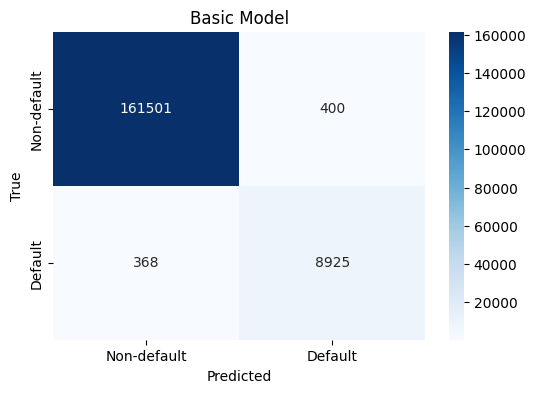

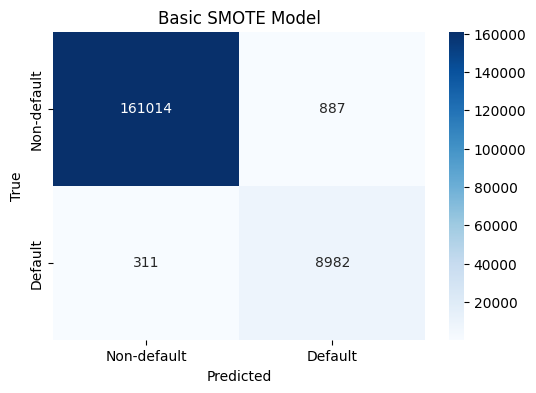

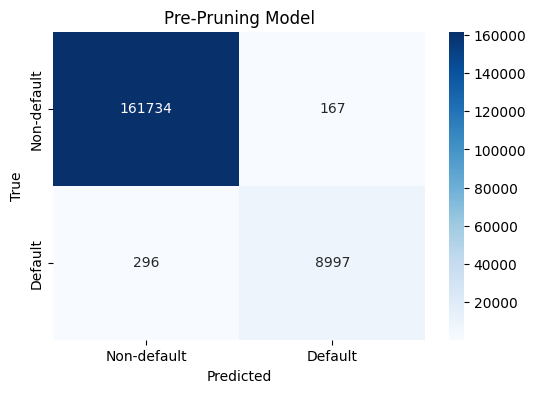

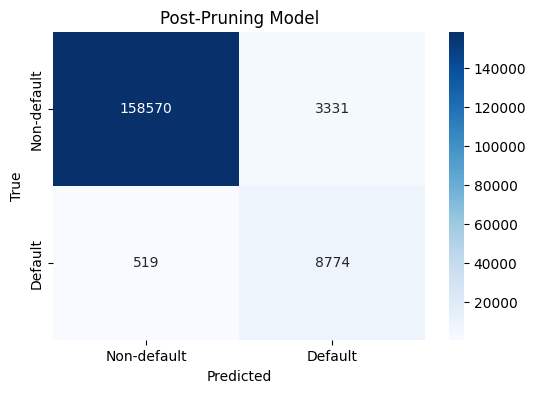

                Model  Accuracy  ROC-AUC Score  Precision (Non-default)  \
0         Basic Model  0.995514       0.978965                 0.997727   
1   Basic SMOTE Model  0.993002       0.980528                 0.998072   
2   Pre-Pruning Model  0.997295       0.983558                 0.998173   
3  Post-Pruning Model  0.977511       0.961789                 0.996738   

   Recall (Non-default)  F1-score (Non-default)  Precision (Default)  \
0              0.997529                0.997628             0.957105   
1              0.994521                0.996294             0.910123   
2              0.998969                0.998571             0.981777   
3              0.979426                0.988006             0.724824   

   Recall (Default)  F1-score (Default)  
0          0.960400            0.958750  
1          0.966534            0.937480  
2          0.968148            0.974915  
3          0.944152            0.820077  


In [61]:
DT_basic_summary = evaluate_predictions(DT_y_test, DT_y_pred_basic, "Basic Model")
DT_basic_SMOTE_summary = evaluate_predictions(DT_y_test, DT_y_pred_basic_smote, "Basic SMOTE Model")
DT_prepruned_summary = evaluate_predictions(DT_y_test, DT_y_pred_prepruned, "Pre-Pruning Model")
DT_postpruned_summary = evaluate_predictions(DT_y_test, DT_y_predict, "Post-Pruning Model")


# Combine all summaries into one DataFrame
DT_all_summaries = pd.concat([DT_basic_summary,DT_basic_SMOTE_summary, DT_prepruned_summary, DT_postpruned_summary], ignore_index=True)
# Display the summary table
print(DT_all_summaries)

#### Conclusion: Since Decision Tree using SMOTE have the best scores across almost all metrics, therefore it is best to use this approach

# NB Classifier

## 1) Fresh round of training

### 1c: Naive Bayes Model training

In [47]:
NB_Xraw_train, NB_Xraw_test, NB_yraw_train, NB_yraw_test = StratifiedSampling(X_before_transformed, y)

nb_classifier_default = GaussianNB()

# Train the classifier on the training data
nb_classifier_default.fit(NB_Xraw_train, NB_yraw_train)

GaussianNB()

In [48]:
NB_yraw_pred = nb_classifier_default.predict(NB_Xraw_test)

Stratified + Oversampling

In [49]:
NB_X_train, NB_X_test, NB_y_train, NB_y_test = Oversampling(X_before_transformed, y)
nb_classifier_default = GaussianNB()

# Train the classifier on the training data
nb_classifier_default.fit(NB_X_train, NB_y_train)

GaussianNB()

In [50]:
NB_y_pred = nb_classifier_default.predict(NB_X_test)

## 2) Fine tune the model

### 2a: + User-defined Transformer Features

In [51]:
# Decide to use new generated features

NB_transformer_with_features = CreditUtilizationRatioTransformer(include=True)

# Apply the transformer to add the new features to df.
NB_df = NB_transformer_with_features.transform(df)

In [52]:
NB_selected_features = selected_features

NB_selected_features.append('Repayment_Progress')
NB_selected_features.append('Loan_Payment_to_Income_Ratio')
NB_selected_features.append('Rev_to_Inc_Ratio')
NB_X1 = NB_df[NB_selected_features]
NB_y1 = NB_df['default_ind']

### 2b: Hyperparameter

In [53]:
# Create a Gaussian Naive Bayes classifier
NB_X1_train, NB_X1_test, NB_y1_train, NB_y1_test = Oversampling(NB_X1, NB_y1)

NB_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
}

nb_classifier_hyper = GaussianNB()
NB_grid_search = GridSearchCV(estimator=nb_classifier_hyper, param_grid=NB_param_grid, cv=5)
NB_grid_search.fit(NB_X1_train, NB_y1_train)

# Step 7: Access the results
NB_best_params = NB_grid_search.best_params_
NB_best_model = NB_grid_search.best_estimator_


In [54]:
NB_y_pred_hyper = NB_best_model.predict(NB_X1_test)

## 3) Evaluate the outcome

#### 3a: Comparison

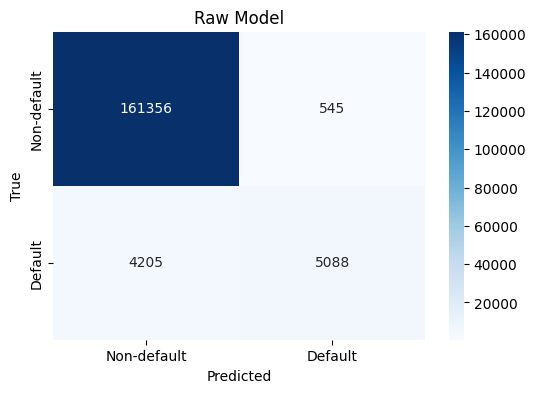

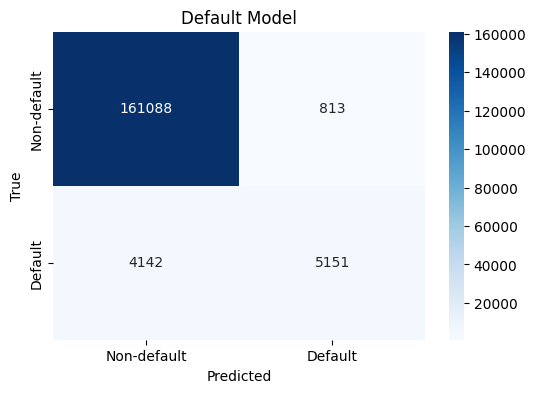

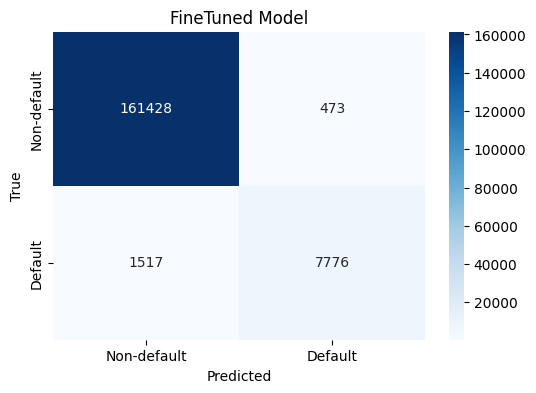

             Model  Accuracy  ROC-AUC Score  Precision (Non-default)  \
0        Raw Model  0.972254       0.772071                 0.974602   
1    Default Model  0.971056       0.774633                 0.974932   
2  FineTuned Model  0.988376       0.916919                 0.990690   

   Recall (Non-default)  F1-score (Non-default)  Precision (Default)  \
0              0.996634                0.985495             0.903249   
1              0.994978                0.984853             0.863682   
2              0.997078                0.993874             0.942660   

   Recall (Default)  F1-score (Default)  
0          0.547509            0.681763  
1          0.554288            0.675231  
2          0.836759            0.886558  


In [55]:
def evaluate_predictions(y_true, y_pred, model_name):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], 
                yticklabels=['Non-default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=['Non-default', 'Default'], output_dict=True)

    # Create a summary table
    summary_table = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'ROC-AUC Score': [roc_auc],
        'Precision (Non-default)': [report['Non-default']['precision']],
        'Recall (Non-default)': [report['Non-default']['recall']],
        'F1-score (Non-default)': [report['Non-default']['f1-score']],
        'Precision (Default)': [report['Default']['precision']],
        'Recall (Default)': [report['Default']['recall']],
        'F1-score (Default)': [report['Default']['f1-score']],
    })

    return summary_table

# Usage:
Raw_summary = evaluate_predictions(NB_yraw_test, NB_yraw_pred, "Raw Model")
Default_summary = evaluate_predictions(NB_y_test, NB_y_pred, "Default Model")
FineTune_summary = evaluate_predictions(NB_y1_test, NB_y_pred_hyper, "FineTuned Model")


# Combine all summaries into one DataFrame
all_summaries = pd.concat([Raw_summary, Default_summary, FineTune_summary], ignore_index=True)

# Display the summary table
print(all_summaries)


### 3b: Conclusion

### Data preprocessing

For data pre-processing: Besides stratified sampling, we used oversampling since the data is imbalanced, resulting in an unequal distribution of default = 1 and default = 0 values. We observed a significant improvement after implementing oversampling: <br><br>
<small> Include the figure for accuracy and chunk of code that is used to calculate accuracy</small>

<br>

In the confusion matrix, the number of wrong predictions for label 1 decreased from <b>4205</b> to <b>4142</b>. Although the overall accuracy decreased, it is acceptable in this case because our main objective is to identify as many default cases as possible. By doing so, the organization can pinpoint customers who are more likely to have a default value of 1. <br>

<small>Include the figure for confusion matrix and can explain the number for true positive and false positive </small>

<br>
    
### Model fine - tuning

Accuracy of default NB: 0.9710562286061427 <br>
Accuracy of default NB (Fine tune): 0.98836407818031 <br>

We can see that after the fine tuning, the accuracry of the model increased. Our intention is to predict as much number of true default as possible. The first thing we do in model fine tuning is to implement the new features that is generated in user defined transformer. The next thing we can tune for NB is var smoothing. This hyperparameter is used to handle numerical stability issues when a feature has zero variance. The default value is 1e-9, and it ensures that no feature has zero variance. By adjusting this parameter, I can control the amount of smoothing applied to the variances of the individual features.



# Random Forest Model

## 1) Fresh round of training

### 1a: RF classifier training

In [56]:
RF_X_train_balanced, RF_X_test, RF_y_train_balanced, RF_y_test = Oversampling(X_before_transformed, y)

# will take 1 min to train
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=10)
rf_classifier.fit(RF_X_train_balanced, RF_y_train_balanced)


KeyboardInterrupt: 

In [ ]:
RF_y_pred = rf_classifier.predict(RF_X_test)

### 1b: StratifiedShuffleSplit Sampling

In [ ]:
RF_X2_train, RF_X2_test, RF_y2_train, RF_y2_test = train_test_split(X_before_transformed, y, test_size=0.2, stratify=y, 
                                                                    random_state=42)
                                                                    
rf_classifier_default = RandomForestClassifier(random_state=42, n_estimators=9)
rf_classifier_default.fit(RF_X2_train, RF_y2_train)

In [ ]:
RF_y_pred_default = rf_classifier_default.predict(RF_X2_test)


## 2) Fine tune the model

### 2a: + User-defined Transformer Features

In [ ]:
# Decide to use new generated features

RF_transformer_with_features = CreditUtilizationRatioTransformer(include=True)

# Apply the transformer to add the new features to df.
RF_df = RF_transformer_with_features.transform(df)

In [ ]:
RF_selected_features = selected_features 

RF_selected_features.append('Repayment_Progress')
RF_selected_features.append('Loan_Payment_to_Income_Ratio')
RF_selected_features.append('Rev_to_Inc_Ratio')
RF_X1 = RF_df[RF_selected_features]
RF_y1 = RF_df['default_ind']

### 2b: Hyperparameter

In [ ]:
RF_X1_train_balanced, RF_X1_test, RF_y1_train_balanced, RF_y1_test = Oversampling(RF_X1, RF_y1)

# around 4 mins to train
rf_classifier_tuned = RandomForestClassifier(n_estimators=9, random_state=42)
RF_param_grid = {
    'max_depth': [5, 6, 7, 8, 9],
    'min_samples_split': [2, 5]
}
RF_grid_search = GridSearchCV(rf_classifier_tuned, RF_param_grid, cv=5, scoring='f1', verbose=1, n_jobs=-1)
RF_best_model = RF_grid_search.fit(RF_X1_train_balanced, RF_y1_train_balanced)

In [ ]:
RF_y_pred_tuned = RF_best_model.predict(RF_X1_test)

## 3) Evaluate the outcome

#### 3a: Comparison

In [ ]:
def evaluate_predictions(y_true, y_pred, model_name):
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], 
                yticklabels=['Non-default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()

    # Generate the classification report
    report = classification_report(y_true, y_pred, target_names=['Non-default', 'Default'], output_dict=True)

    # Create a summary table
    summary_table = pd.DataFrame({
        'Model': [model_name],
        'Accuracy': [accuracy],
        'ROC-AUC Score': [roc_auc],
        'Precision (Non-default)': [report['Non-default']['precision']],
        'Recall (Non-default)': [report['Non-default']['recall']],
        'F1-score (Non-default)': [report['Non-default']['f1-score']],
        'Precision (Default)': [report['Default']['precision']],
        'Recall (Default)': [report['Default']['recall']],
        'F1-score (Default)': [report['Default']['f1-score']],
    })

    return summary_table

# Usage:
basic_summary = evaluate_predictions(RF_y_test, RF_y_pred_default, "Basic Model")
balanced_summary = evaluate_predictions(RF_y_test, RF_y_pred, "Balanced Model")
tuned_summary = evaluate_predictions(RF_y_test, RF_y_pred_tuned, "Fine-Tuned Model")

# Combine all summaries into one DataFrame
all_summaries = pd.concat([basic_summary, balanced_summary, tuned_summary], ignore_index=True)
print(all_summaries)

### Conclusion


Based on the result, we can see that even with fine - tuning, the accuracy of random forest model is high, around 99.7%. However, the model before fine tuning still miss out a lot of default values. For this case, since default is not good, we are trying to predict as much true default as possible. <br> 

After the fine tuning, we can see that the accuracy slightly increased, and the true default that is detected is also increased, and it only missed out 225 default cases. 